In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import autoreload

In [3]:
try:
    output_filepath
except:
    output_filepath = 's3://workspaces-clarity-mgmt-pro/jaime.oliver/misc/social_capital/data/processed_3/'
    input_filepath = 's3://workspaces-clarity-mgmt-pro/jaime.oliver/misc/social_capital/data/raw/'

In [4]:
import pandas as pd
import numpy as np
import os
from utils import data_loader
import seaborn as sns
import matplotlib.pyplot as plt

from linearmodels.iv import IV2SLS, IVGMM
from linearmodels.iv.results import compare

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline

from arellano_bond import PanelLaggedDep

In [5]:
reduced_terms_list, df_model = data_loader(output_filepath)
df_model = df_model[df_model.year.between(1993, 2016)]

Text(0, 0.5, 'cumulative explained variance')

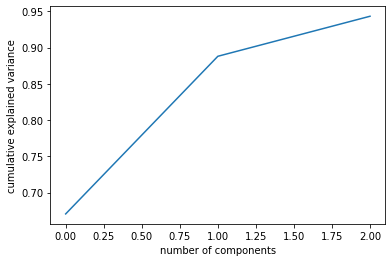

In [6]:
n = 3

pipe = Pipeline([
        ('scale', StandardScaler()),
        ('reduce_dims', PCA(n_components=n))]
        )

df_model[[f'pca_{i}' for i in range(n)]] = pipe.fit_transform(df_model[reduced_terms_list])

pipe = Pipeline([
        ('scale', StandardScaler()),
        ('reduce_dims', PCA(n_components=n))]
        )
pipe.fit(df_model[reduced_terms_list])

plt.plot(np.cumsum(pipe['reduce_dims'].explained_variance_ratio_))
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance')

## Anderson Hsiao / Arellano bond estimates
Suspecting there is reverse causality, we introduce the endogenouos variable as a regressor to reduce it:
$$\log GDP_t = \beta PCA_t + \log GDP_{t-1} + \Delta\epsilon$$

We estimate the model in differences
$$\Delta\log GDP_t = \beta\Delta PCA_t + \Delta\log GDP_{t-1} + \Delta\epsilon$$

As instruments for $\Delta\log GDP_{t-1}$ we use lagged values (t>2) of  $\log GDP$, which are:
- Exogenous: only related to future values of $\Delta\log GDP_t$ through $\Delta\log GDP_{t-1}$
- Relevant: related to lagged PCA

Depending on the number of lags used: 
- Anderson-Hsiao: 1 lag
- Arellano-Bond: all available

In [7]:
df_index = df_model.set_index(['country', 'year'])

In [8]:
model = PanelLaggedDep(endog = df_index['log_gdp'],
                       exogs = df_index[reduced_terms_list], 
                       systemGMM = False,
                       iv_max_lags=1,
                       add_intercept=True,                       
                       entity_effects=False,
                       weight_type='clustered')

results = model.fit()

print(results.summary)

                          IV-GMM Estimation Summary                           
Dep. Variable:               Dlog_gdp   R-squared:                      0.1477
Estimator:                     IV-GMM   Adj. R-squared:                 0.1370
No. Observations:                 567   F-statistic:                    44.059
Date:                Mon, Jan 24 2022   P-value (F-stat)                0.0000
Time:                        17:36:53   Distribution:                  chi2(7)
Cov. Estimator:                robust                                         
                                                                              
                                   Parameter Estimates                                    
                        Parameter  Std. Err.     T-stat    P-value    Lower CI    Upper CI
------------------------------------------------------------------------------------------
Dfinancial_hubs           -0.7651     0.2333    -3.2787     0.0010     -1.2224     -0.3077
Dfin

/repos/social_capital_in_trade_networks/notebooks/arellano_bond.py:134: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dropped['CLUSTER_VAR'] = dropped.index.get_level_values(0)


In [9]:
df_index = df_model.set_index(['country', 'year'])
model = PanelLaggedDep(endog = df_index['log_gdp'],
                       exogs = df_index[[f'pca_{i}' for i in range(n)]], 
                       systemGMM = False,
                       iv_max_lags=1,
                       lags=1,
                       add_intercept=True,
                       entity_effects=False,
                       weight_type='kernel')

results = model.fit()

print(results.summary)

                          IV-GMM Estimation Summary                           
Dep. Variable:               Dlog_gdp   R-squared:                      0.0875
Estimator:                     IV-GMM   Adj. R-squared:                 0.0810
No. Observations:                 567   F-statistic:                    12.977
Date:                Mon, Jan 24 2022   P-value (F-stat)                0.0114
Time:                        17:36:53   Distribution:                  chi2(4)
Cov. Estimator:                robust                                         
                                                                              
                             Parameter Estimates                              
            Parameter  Std. Err.     T-stat    P-value    Lower CI    Upper CI
------------------------------------------------------------------------------
Dpca_0         0.0223     0.0354     0.6302     0.5285     -0.0471      0.0917
Dpca_1        -0.0910     0.0457    -1.9908     0.04

In [10]:
df_index = df_model.set_index(['country', 'year'])
model = PanelLaggedDep(endog = df_index['pca_2'],
                       exogs = df_index[['log_gdp']], 
                       systemGMM = False,
                       iv_max_lags=1,
                       lags=1, 
                       add_intercept=True)

results = model.fit()

print(results.summary)

                          IV-GMM Estimation Summary                           
Dep. Variable:                 Dpca_2   R-squared:                     -0.1840
Estimator:                     IV-GMM   Adj. R-squared:                -0.1882
No. Observations:                 567   F-statistic:                    2.3392
Date:                Mon, Jan 24 2022   P-value (F-stat)                0.3105
Time:                        17:36:53   Distribution:                  chi2(2)
Cov. Estimator:                robust                                         
                                                                              
                             Parameter Estimates                              
            Parameter  Std. Err.     T-stat    P-value    Lower CI    Upper CI
------------------------------------------------------------------------------
Dlog_gdp       0.0734     0.1051     0.6987     0.4848     -0.1325      0.2794
constant      -0.0089     0.0147    -0.6021     0.54

/repos/social_capital_in_trade_networks/notebooks/arellano_bond.py:134: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dropped['CLUSTER_VAR'] = dropped.index.get_level_values(0)
